In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
sys.path.append(my_local_drive)

In [3]:
!jupyter nbconvert --to python "/content/gdrive/My Drive/Colab Notebooks/ML_FDS/clip_training.ipynb"

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Colab Notebooks/ML_FDS/clip_training.ipynb to python
[NbConvertApp] Writing 21448 bytes to /content/gdrive/My Drive/Colab Notebooks/ML_FDS/clip_training.py


In [28]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path
import datetime

from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import pickle

import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import TextVectorization


In [16]:
import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/ML_FDS")

from clip_training import MaskedMean, ClipLossLayer, L2Normalize, SmallBERT

In [42]:
dataset_dir = "./flickr_subset2"
train_dir = os.path.join(dataset_dir, "train_data")
captions_path = os.path.join(train_dir, "captions.csv")
vocab_path = os.path.join(dataset_dir, "vocab.txt")
model_dir = dataset_dir
sequence_length = 32
vocab_size = 10000

In [18]:
model = tf.keras.models.load_model(
    "clip_model.h5",
    custom_objects={
        "MaskedMean": MaskedMean,
        "ClipLossLayer": ClipLossLayer,
        "L2Normalize": L2Normalize,
        "SmallBERT": SmallBERT
    }
)

print("Model loaded!")

Model loaded!


In [8]:
for layer in model.layers:
    print(layer.name)


image_input
rescaling
conv2d
max_pooling2d
text_input
flatten
small_bert
dense_4
masked_mean
image_latent_vector
text_latent_vector
clip_loss_layer


In [9]:
model.inputs

[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=image_input>,
 <KerasTensor shape=(None, 32), dtype=int32, sparse=False, ragged=False, name=text_input>]

In [20]:
image_input = model.inputs[0]
image_output = model.get_layer("image_latent_vector").output

image_encoder = tf.keras.Model(
    inputs=image_input,
    outputs=image_output,
    name="image_encoder"
)

print("Image encoder created")

Image encoder created


In [21]:
text_input = model.inputs[1]
text_output = model.get_layer("text_latent_vector").output

text_encoder = tf.keras.Model(
    inputs=text_input,
    outputs=text_output,
    name="text_encoder"
)

print("Text encoder created")


Text encoder created


In [24]:
tokenizer = TextVectorization(
    max_tokens=vocab_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    vocabulary=vocab_path,
    pad_to_max_tokens=True,
    output_sequence_length=sequence_length,
    output_mode="int"
)


In [43]:
df = pd.read_csv(captions_path)
image_paths = [str(Path(dataset_dir) / p) for p in df["image_path"]]

embeddings = []
for i in range(0, len(image_paths), 32):
    batch = image_paths[i:i+32]
    imgs = np.array([img_to_array(load_img(p, target_size=(224, 224)))/255. for p in batch])
    embeddings.append(image_encoder.predict(imgs, verbose=0))

image_embeddings = np.vstack(embeddings)

db = {'paths': image_paths, 'embeddings': image_embeddings}
with open(f"{model_dir}/image_db.pkl", 'wb') as f:
    pickle.dump(db, f)

df_embeddings = pd.DataFrame(image_embeddings)
df_embeddings.insert(0, 'image_path', image_paths)
df_embeddings.to_csv(f"{model_dir}/image_embeddings.csv", index=False)

print(f"Saved image embeddings: {image_embeddings.shape}")

Saved image embeddings: (480, 128)


In [44]:
captions = df["caption"].fillna("").tolist()

embeddings = []
for i in range(0, len(captions), 32):
    batch = captions[i:i+32]
    tokens = tokenizer(batch)
    embeddings.append(text_encoder.predict(tokens, verbose=0))

text_embeddings = np.vstack(embeddings)

db = {'captions': captions, 'embeddings': text_embeddings}
with open(f"{model_dir}/text_db.pkl", 'wb') as f:
    pickle.dump(db, f)
df_embeddings = pd.DataFrame(text_embeddings)
df_embeddings.insert(0, 'captions_path', captions_path)
df_embeddings.to_csv(f"{model_dir}/text_embeddings.csv", index=False)
print(f"Saved text embeddings: {text_embeddings.shape}")

Saved text embeddings: (480, 128)


In [45]:
def search_images(query, top_k=10):
    with open(f"{model_dir}/image_db.pkl", 'rb') as f:
        db = pickle.load(f)

    tokens = tokenizer([query])
    query_emb = text_encoder.predict(tokens, verbose=0)
    sims = (db['embeddings'] @ query_emb.T).squeeze()
    top_idx = np.argsort(sims)[::-1][:top_k]

    return [(db['paths'][i], sims[i]) for i in top_idx]

#petit test
results = search_images("bike ride", top_k=5)
for i, (path, score) in enumerate(results, 1):
    print(f"{i}. Score: {score:.3f} | {path}")

1. Score: 0.006 | flickr_subset2/images/ball/ball_124.jpg
2. Score: 0.006 | flickr_subset2/images/dog/dog_113.jpg
3. Score: 0.005 | flickr_subset2/images/bike/bike_055.jpg
4. Score: 0.005 | flickr_subset2/images/bike/bike_140.jpg
5. Score: 0.005 | flickr_subset2/images/ball/ball_095.jpg


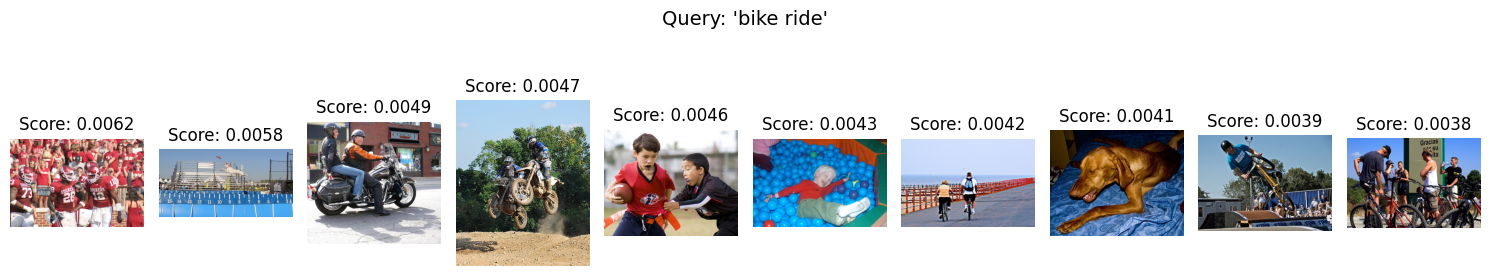

In [47]:
#test avec preview images
import matplotlib.pyplot as plt
from PIL import Image

def search_and_display(query, top_k=5):
    with open(f"{model_dir}/image_db.pkl", 'rb') as f:
        db = pickle.load(f)

    tokens = tokenizer([query])
    query_emb = text_encoder.predict(tokens, verbose=0)
    sims = (db['embeddings'] @ query_emb.T).squeeze()
    top_idx = np.argsort(sims)[::-1][:top_k]

    results = [(db['paths'][i], sims[i]) for i in top_idx]

    fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
    if top_k == 1:
        axes = [axes]

    for idx, (ax, (path, score)) in enumerate(zip(axes, results)):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(f"Score: {score:.4f}")
        ax.axis('off')

    plt.suptitle(f"Query: '{query}'", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return results

# Test
results = search_and_display("bike ride", top_k=10)

In [40]:
with open(f"{model_dir}/image_db.pkl", 'rb') as f:
    db = pickle.load(f)

#print(str(db)[:1000])
print(db)

{'paths': ['flickr_subset2/images/ball/ball_029.jpg', 'flickr_subset2/images/water/water_090.jpg', 'flickr_subset2/images/ball/ball_057.jpg', 'flickr_subset2/images/bike/bike_095.jpg', 'flickr_subset2/images/ball/ball_106.jpg', 'flickr_subset2/images/bike/bike_136.jpg', 'flickr_subset2/images/bike/bike_107.jpg', 'flickr_subset2/images/bike/bike_038.jpg', 'flickr_subset2/images/ball/ball_114.jpg', 'flickr_subset2/images/bike/bike_048.jpg', 'flickr_subset2/images/water/water_135.jpg', 'flickr_subset2/images/bike/bike_146.jpg', 'flickr_subset2/images/ball/ball_018.jpg', 'flickr_subset2/images/ball/ball_008.jpg', 'flickr_subset2/images/dog/dog_005.jpg', 'flickr_subset2/images/ball/ball_102.jpg', 'flickr_subset2/images/dog/dog_023.jpg', 'flickr_subset2/images/dog/dog_117.jpg', 'flickr_subset2/images/water/water_111.jpg', 'flickr_subset2/images/dog/dog_074.jpg', 'flickr_subset2/images/bike/bike_106.jpg', 'flickr_subset2/images/water/water_040.jpg', 'flickr_subset2/images/dog/dog_016.jpg', 'f